In [1]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Direktori dataset
train_dir = '../dataset/data/train'
val_dir = '../dataset/data/val'
test_dir = '../dataset/data/test'

# Create a training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,  # You can adjust the validation split as needed
    subset="training",
    seed=1337,  # You can use any seed value
    image_size=(img_height, img_width),  # Specify your desired image size
    batch_size=batch_size,
)

# Create a validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,  # Same validation split as in the training dataset
    subset="validation",
    seed=1337,  # Use the same seed as the training dataset
    image_size=(img_height, img_width),  # Specify your desired image size
    batch_size=batch_size,
)

# Create a validation dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=1337,  # Use the same seed as the training dataset
    image_size=(img_height, img_width),  # Specify your desired image size
    batch_size=batch_size,
)

# Define the class names
class_names = train_dataset.class_names

Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 98 files belonging to 2 classes.
Using 19 files for validation.
Found 98 files belonging to 2 classes.


2023-12-02 02:35:06.101367: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-02 02:35:06.101387: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-02 02:35:06.101393: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-02 02:35:06.101443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-02 02:35:06.101780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = train_dataset.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape
)

base_model.trainable = False

In [6]:
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_names), activation= 'softmax')
])


In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
history = model.fit(train_dataset, validation_data = validation_dataset, epochs = 50)

Epoch 1/50


2023-12-02 02:35:08.009849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 141ms/step - loss: 0.8626 - accuracy: 0.5434 - val_loss: 0.6988 - val_accuracy: 0.6316
Epoch 2/50
20/20 [==============================] - 3s 109ms/step - loss: 0.5672 - accuracy: 0.7188 - val_loss: 0.4846 - val_accuracy: 0.7368
Epoch 3/50
20/20 [==============================] - 3s 116ms/step - loss: 0.3774 - accuracy: 0.8341 - val_loss: 0.3842 - val_accuracy: 0.8421
Epoch 4/50
20/20 [==============================] - 3s 109ms/step - loss: 0.2372 - accuracy: 0.9068 - val_loss: 0.6600 - val_accuracy: 0.6842
Epoch 5/50
20/20 [==============================] - 3s 113ms/step - loss: 0.1458 - accuracy: 0.9558 - val_loss: 0.3898 - val_accuracy: 0.7895
Epoch 6/50
20/20 [==============================] - 3s 111ms/step - loss: 0.1535 - accuracy: 0.9368 - val_loss: 0.3292 - val_accuracy: 0.8947
Epoch 7/50
20/20 [==============================] - 3s 123ms/step - loss: 0.0775 - accuracy: 0.9668 - val_loss: 0.3025 - val_accuracy: 0.8947
Epoch 8/50
20/20 

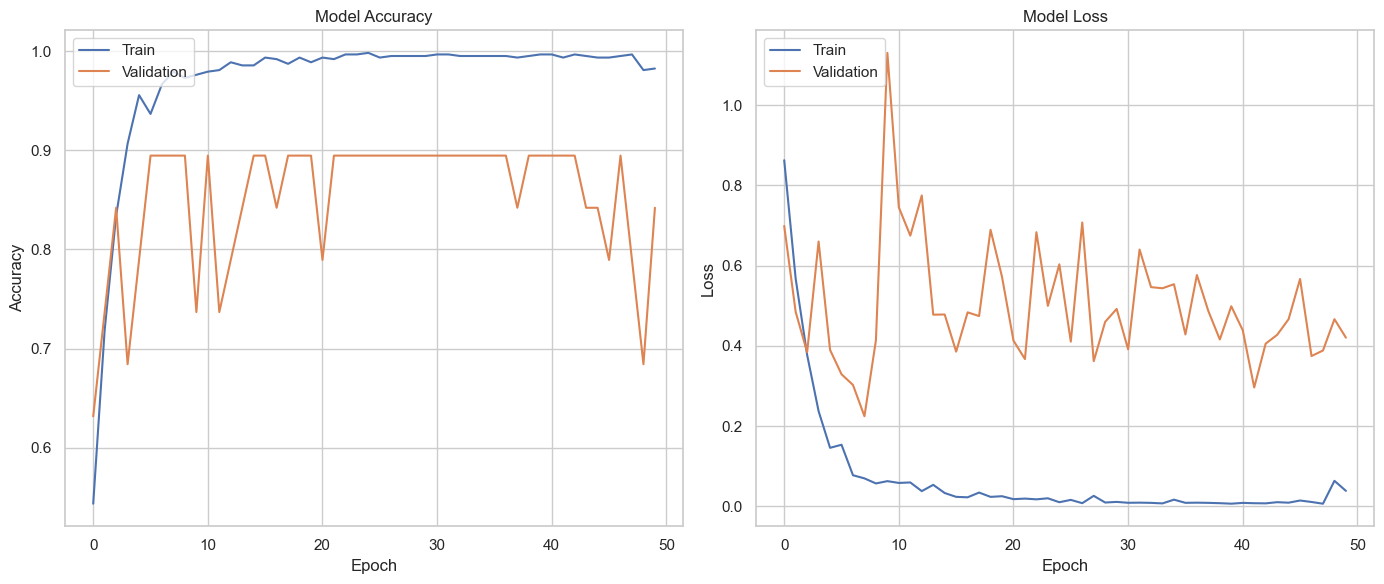

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style and context
sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report
import numpy as np

y_true = np.concatenate([y for x, y in testing_ds])

y_pred = model.predict(testing_ds)
y_pred = np.argmax(y_pred, axis=1) # Convert probabilities to class indices

report = classification_report(y_true, y_pred, target_names=class_names)

print(report)

4/4 [==============================] - 1s 159ms/step
              precision    recall  f1-score   support

    Accident       0.87      0.87      0.87        46
Non Accident       0.88      0.88      0.88        52

    accuracy                           0.88        98
   macro avg       0.88      0.88      0.88        98
weighted avg       0.88      0.88      0.88        98



1/1 [==============================] - 1s 696ms/step


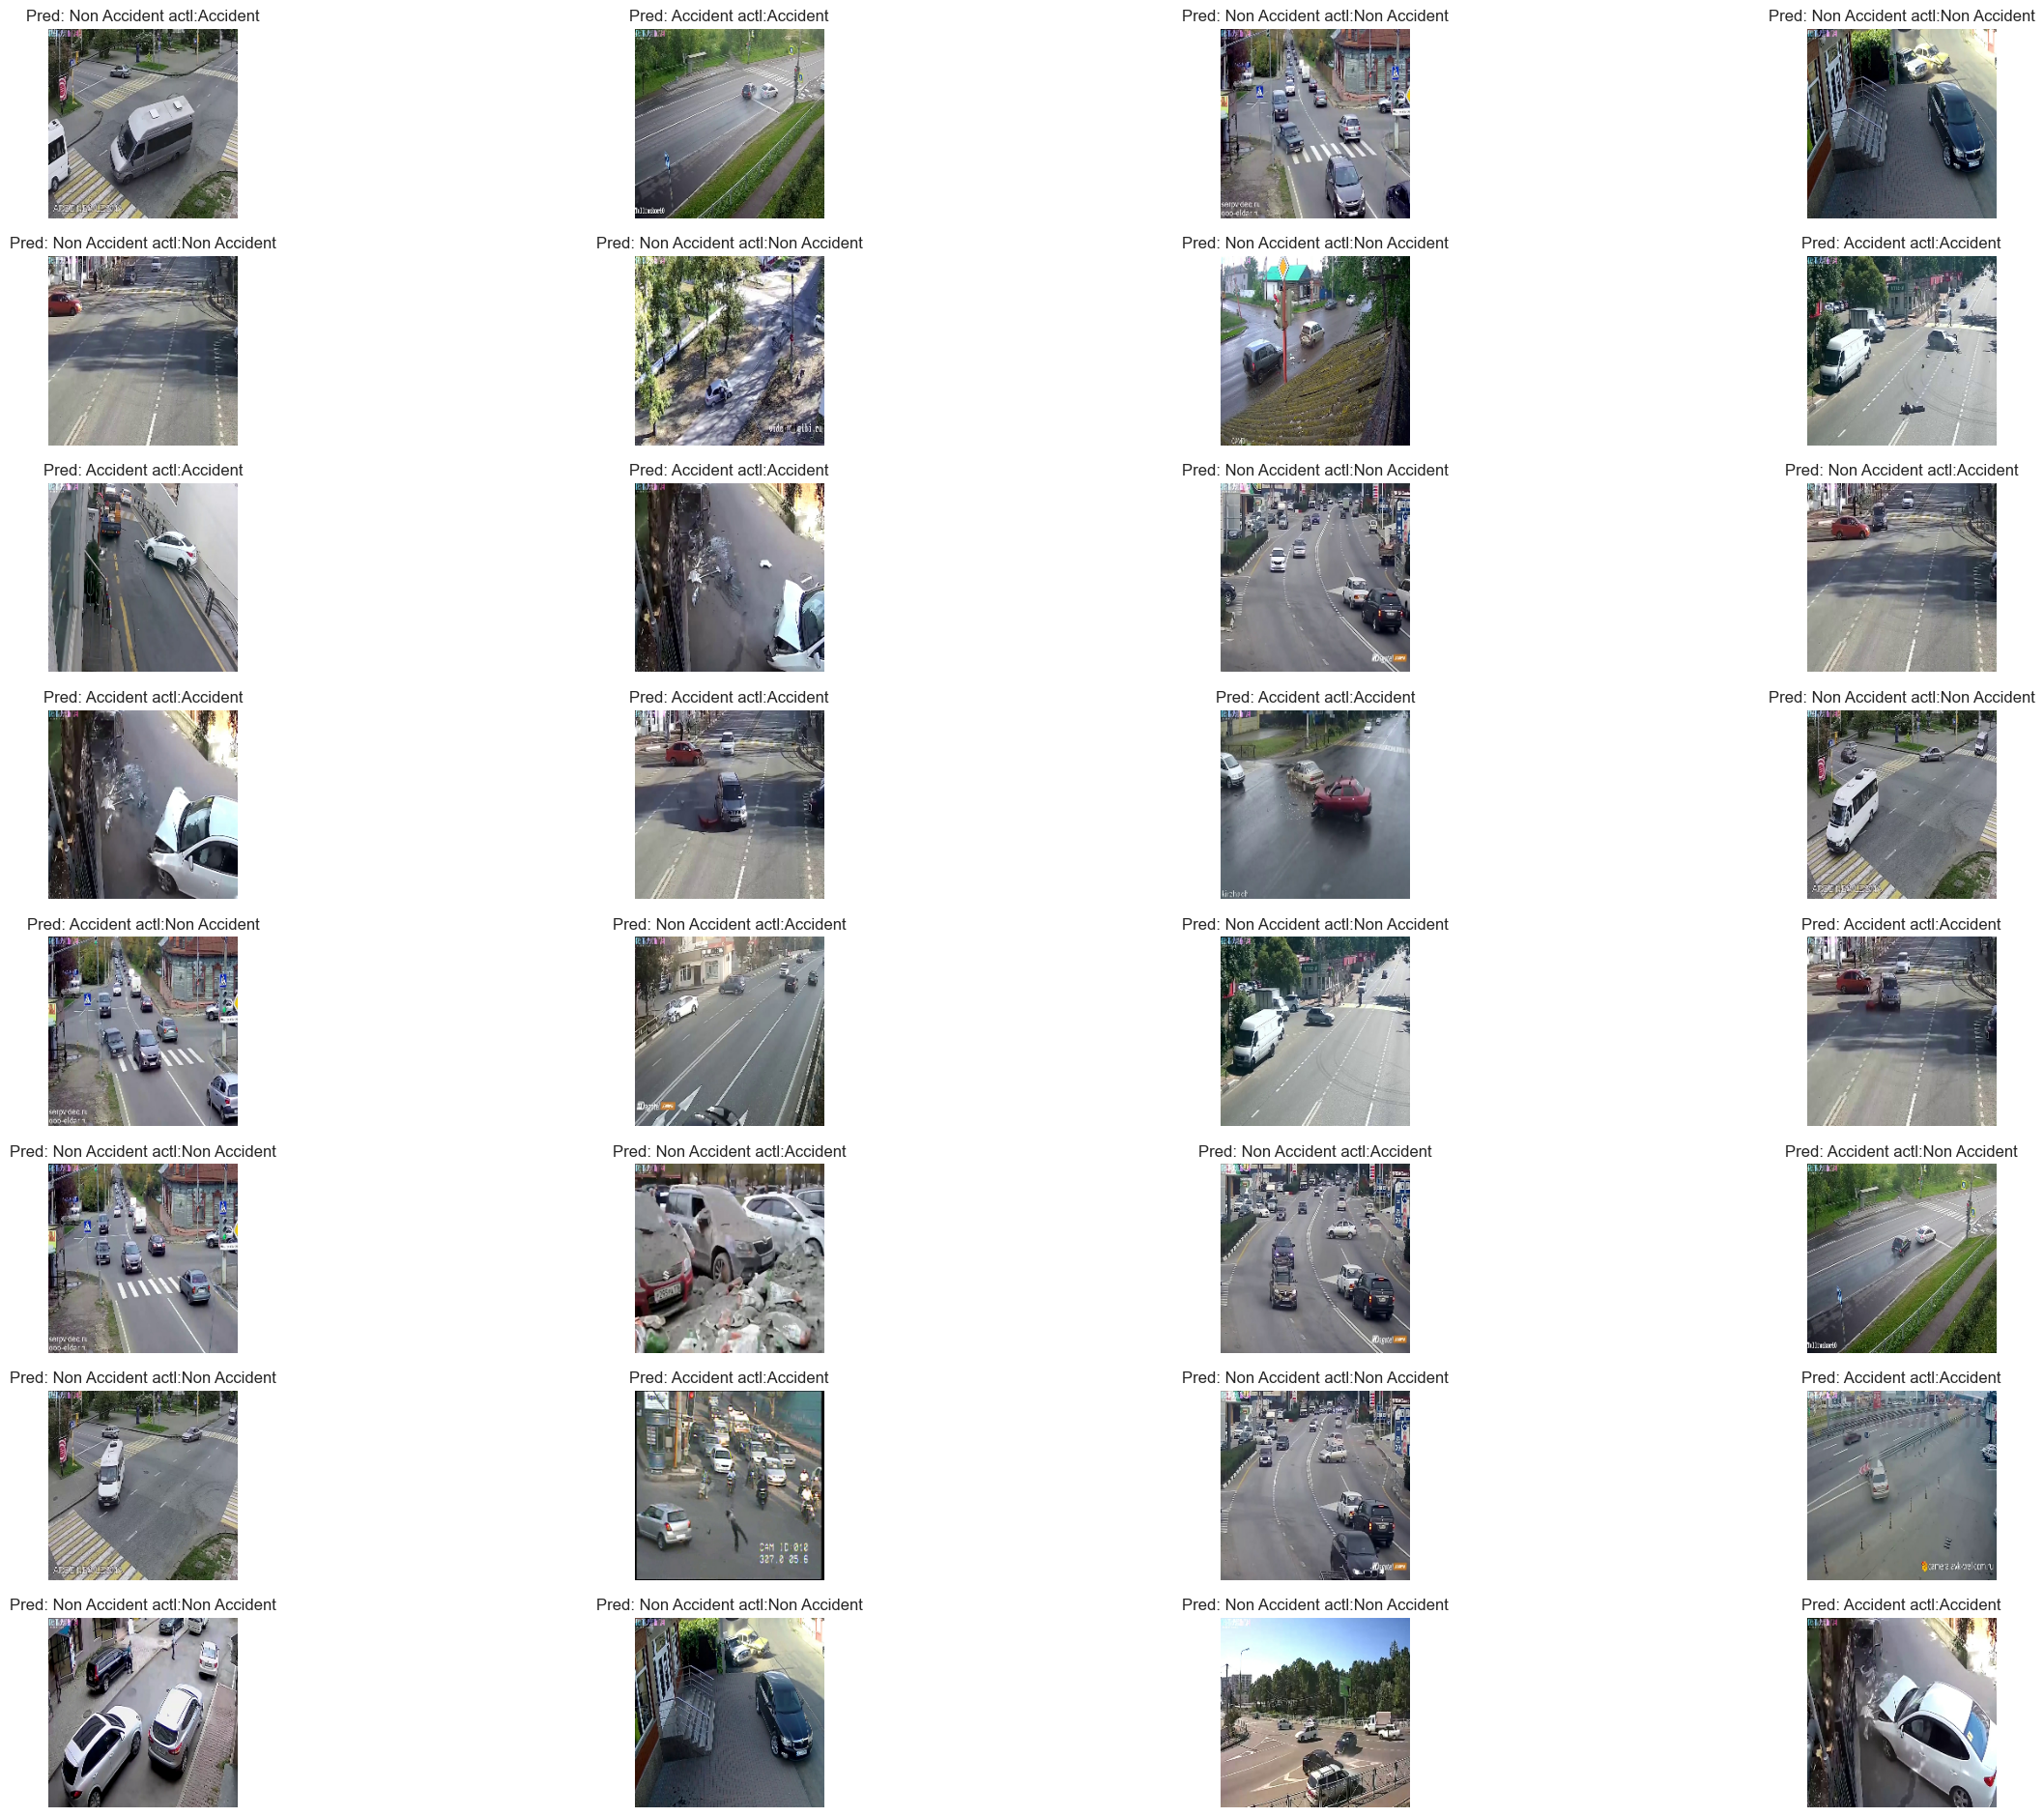

In [11]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(32):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

4/4 [==============================] - 0s 135ms/step


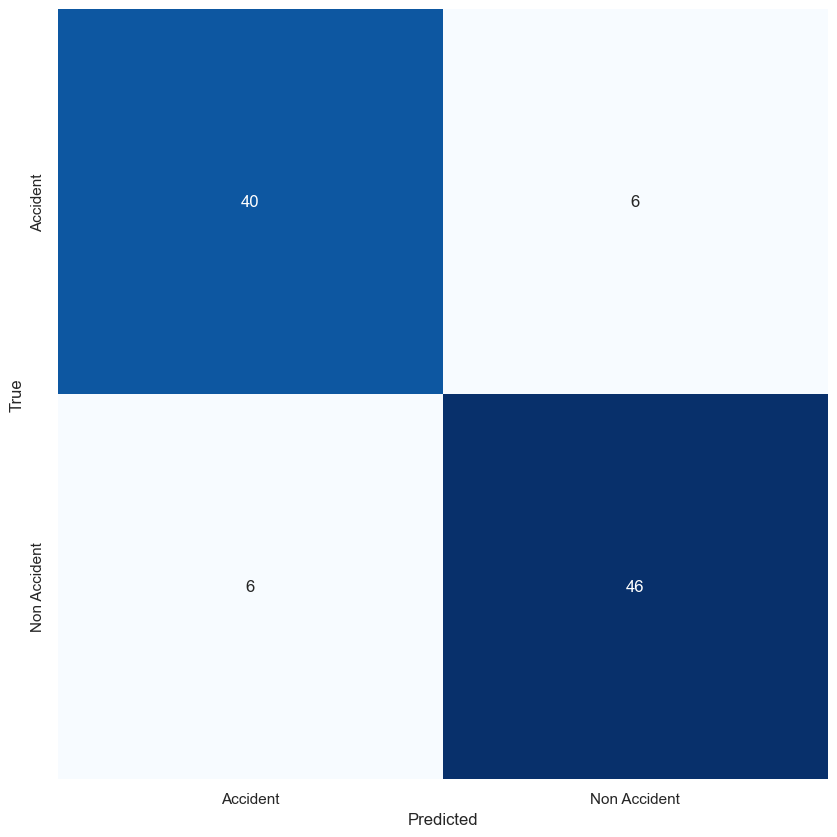

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = np.concatenate([y for x, y in testing_ds])

y_pred = model.predict(testing_ds)
y_pred = np.argmax(y_pred, axis=1) # Convert probabilities to class indices

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
model.save("model_cv.keras")